In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
from datetime import *
from sklearn import linear_model
from sklearn.preprocessing import *
from sklearn import ensemble
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.externals import joblib
from fbprophet import Prophet

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#导入训练数据
train_data = pd.read_csv('prophet_fusai_B_fullfilling_train_feature_set.csv')

print(len(train_data))
train_data = train_data[train_data.guess_date < '2015-10-01']
print(len(train_data))

print(train_data.head(10))

13245
9475
   date  brand  cnt  day_of_week  week  guess_date  date_year  date_month  \
0     1      1   31            2     0  2013-01-01       2013           1   
1     1      6    6            2     0  2013-01-01       2013           1   
2     1      9   15            2     0  2013-01-01       2013           1   
3     2      9    0            3     0  2013-01-02       2013           1   
4     2      8    0            3     0  2013-01-02       2013           1   
5     2      3    0            3     0  2013-01-02       2013           1   
6     2      2    0            3     0  2013-01-02       2013           1   
7     2      7   30            3     0  2013-01-02       2013           1   
8     2      6    6            3     0  2013-01-02       2013           1   
9     2      4   20            3     0  2013-01-02       2013           1   

   date_property guess_date_str    ...     brand_1 brand_2  brand_3  brand_4  \
0              2     2013-01-01    ...           1       0   

In [3]:
#根据prophet定义训练集
df_allBrand = train_data
df_allBrand['guess_date'] = df_allBrand['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_allBrand.rename(columns = {'guess_date':'ds', 'cnt':'y', 'brand':'brand'}, inplace=True)

In [4]:
#为模型添加节假日特征
#元旦
NewYearDay = pd.DataFrame({
  'holiday': 'NewYearDay',
  'ds': pd.to_datetime(['2013-01-01', '2013-01-02', '2013-01-03',
                        '2014-01-01', 
                        '2015-01-01', '2015-01-02', '2015-01-03',
                        '2016-01-01', '2016-01-02', '2016-01-03'])
})

#春节
ChineseNewYearDay = pd.DataFrame({
  'holiday': 'ChineseNewYearDay',
  'ds': pd.to_datetime(['2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15',
                        '2014-01-31', '2014-02-01', '2014-02-03', '2014-02-04', '2014-02-05', '2014-02-06', '2014-05-02', 
                        '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24',
                        '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13'])
})

#国庆节
NationalDay = pd.DataFrame({
  'holiday': 'NationalDay',
  'ds': pd.to_datetime(['2013-10-01', '2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05', '2013-10-06', '2013-10-07',
                        '2014-10-01', '2014-10-02', '2014-10-03', '2014-10-04', '2014-10-05', '2014-10-06', '2014-10-07', 
                        '2015-10-01', '2015-10-02', '2015-10-03', '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07',
                        '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05', '2016-10-06', '2016-10-07'])
})

#劳动节
MayDay = pd.DataFrame({
  'holiday': 'MayDay',
  'ds': pd.to_datetime(['2013-04-29', '2013-04-30', '2013-05-01',
                        '2014-05-01', '2014-05-02', '2014-05-03',  
                        '2015-05-01', '2015-05-02', '2015-05-03',
                        '2016-05-01', '2016-05-02', '2016-04-30'])
})

#清明节
ChingMingDay = pd.DataFrame({
  'holiday': 'ChingMingDay',
  'ds': pd.to_datetime(['2013-04-04', '2013-04-05', '2013-04-06',
                        '2014-04-05', '2014-04-06', '2014-04-07',  
                        '2015-04-04', '2015-04-05', '2015-04-06',
                        '2016-04-02', '2016-04-03', '2016-04-04'])
})

#端午节
DragonBoatDay = pd.DataFrame({
  'holiday': 'DragonBoatDay',
  'ds': pd.to_datetime(['2013-06-10', '2013-06-11', '2013-06-12',
                        '2014-05-31', '2014-06-01', '2014-06-02',  
                        '2015-06-20', '2015-06-21', '2015-06-22',
                        '2016-06-09', '2016-06-10', '2016-06-11'])
})

#中秋节
MidAutumnDay = pd.DataFrame({
  'holiday': 'MidAutumnDay',
  'ds': pd.to_datetime(['2013-09-19', '2013-09-20', '2013-09-21',
                        '2014-09-06', '2014-09-07', '2014-09-08',  
                        '2015-09-26', '2015-09-27',
                        '2015-09-03', '2015-09-04', '2015-09-05',
                        '2016-09-15', '2016-09-16', '2016-09-17'])
})

holidays = pd.concat((NewYearDay, ChineseNewYearDay, NationalDay, MayDay, ChingMingDay, DragonBoatDay, MidAutumnDay))

In [5]:
#导入预测数据集
test_data1 = pd.read_csv('fusai_A_test_feature_set.csv')
test_data2 = pd.read_csv('fusai_A_train_feature_set.csv')
print(len(test_data1))
print(len(test_data2))
test_data = pd.concat([test_data2[test_data2.guess_date > '2015-09-31'], test_data1])
print(len(test_data))
test_data['guess_date'] = test_data['guess_date'].map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
test_data.rename(columns = {'guess_date':'ds'}, inplace=True)

1289
8971
3007


In [20]:
#定义根据date_property是否为0，预测数据的函数
def predictByProphet(df_train, df_test, holidays, cap, floor, none_value, changepoint_prior_scale,
                            interval_width, regressor_set, changepoints):
    #处理训练集相关数据
    df_train['y'] = df_train['y'].map(lambda x: None if x > none_value else x)
    #定义最大值和最小值
    df_train['cap'] = cap
    df_train['floor'] = floor
    
    #定义prophet模型和预测集
    m = Prophet(growth = 'logistic', holidays = holidays, changepoints = changepoints,
                changepoint_prior_scale = changepoint_prior_scale, interval_width = interval_width)
    m.add_seasonality(name = 'weekly', period = 7, fourier_order = 3)
    
    #添加额外特征
    for regressor_future in regressor_set:
        m.add_regressor(regressor_future)
        
    m.fit(df_train)
    
    #处理测试集相关数据
    test_data = pd.concat([df_train.drop('y', 1), df_test])
    test_data['cap'] = cap
    test_data['floor'] = floor
    
    forcast = m.predict(test_data)
    return m, forcast

df_brand9_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand9_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand9_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand9_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property != 0)]
m_brand9_restday, forcast_brand9_restday = predictByProphet(df_brand9_restday, test_data_brand9_restday, holidays, 500, -500, 500, 0.5,
                0.95, df_brand9_restday_regressor_set, brand9_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
287 2015-06-27  102.103533   22.000266  203.558376
288 2015-06-28   28.593363  -52.999977  111.892875
289 2015-07-04  118.624418   28.672811  204.614769
290 2015-07-05   43.679933  -42.656070  127.076804
291 2015-07-11  121.835331   33.709107  213.729319
292 2015-07-12   44.684911  -45.678879  135.141462
293 2015-07-18  111.428183   24.068519  198.987814
294 2015-07-19   32.950020  -57.190774  124.061843
295 2015-07-25   96.658773   12.972735  188.403672
296 2015-07-26   18.511887  -70.966887  110.125565
297 2015-08-01   88.158483   -6.080664  177.518968
298 2015-08-02   11.457434  -78.124730   93.245638
299 2015-08-08   90.223101    1.731656  184.493813
300 2015-08-09   14.892755  -71.528978  102.532676
301 2015-08-15   99.381751    7.012911  192.068426
302 2015-08-16   24.501624  -65.829243  110.073174
303 2015-08-22  108.623400   17.416132  201.887975
304 2015-08-23   33.237550  -56.449240  122.499099
305 2015-08-29  112.766567   27

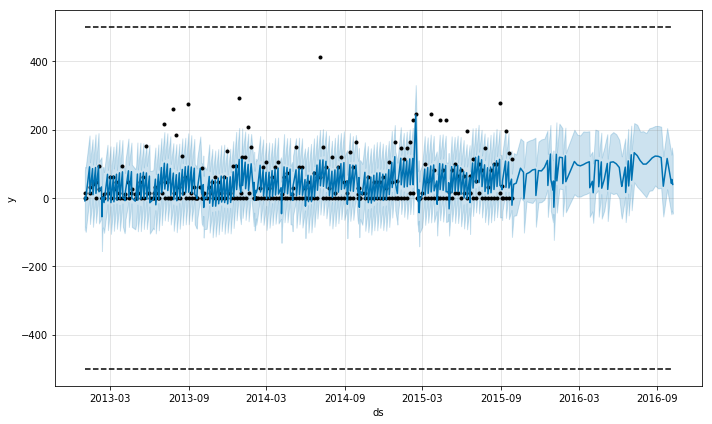

In [21]:
print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_restday.ds < '2016-01-10') & (forcast_brand9_restday.ds > '2016-01-01')])
m_brand9_restday.plot(forcast_brand9_restday)

In [22]:
df_brand9_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 9) 
                                          & (train_data.date_property == 0)]
df_brand9_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand9_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand9_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 9) & (test_data.date_property == 0)]
m_brand9_workday, forcast_brand9_workday = predictByProphet(df_brand9_workday, test_data_brand9_workday, holidays, 1500, -300, 1800, 0.5,
                0.95, df_brand9_workday_regressor_set, brand9_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds         yhat  yhat_lower   yhat_upper
841 2016-05-18   695.580839  347.824928  1079.500857
842 2016-05-19   583.941717  237.505476   945.488069
843 2016-05-20   657.048971  320.423949  1009.046552
844 2016-05-23   711.304153  354.956738  1047.468539
845 2016-05-24   733.223791  381.982574  1087.060530
846 2016-05-25   669.896439  315.846981  1023.298761
847 2016-05-26   554.392119  198.565018   901.290123
848 2016-05-27   623.953785  273.063180   970.903121
849 2016-05-30   670.120171  331.341253  1002.315089
850 2016-05-31   690.375461  338.487622  1068.954502
851 2016-06-01   625.973183  279.392794   995.049720
852 2016-06-02   510.014586  166.082299   867.421326
853 2016-06-03   579.764101  244.801447   919.202938
854 2016-06-06   630.403592  302.883440   976.967570
855 2016-06-07   653.417303  287.023893   986.893213
856 2016-06-08   592.361803  249.581278   941.989792
857 2016-06-12   789.580313  411.335046  1153.360056
858 2016-06-13   620.458320  262.289573   994.

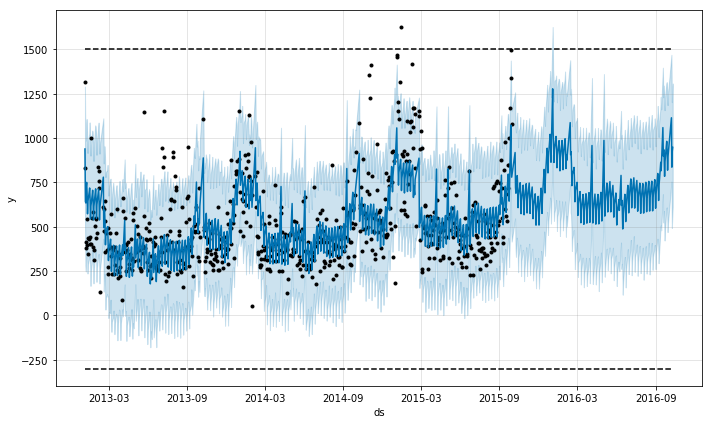

In [23]:
print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand9_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand9_workday.ds < '2016-01-10') & (forcast_brand9_workday.ds > '2016-01-01')])
m_brand9_workday.plot(forcast_brand9_workday)

In [24]:
brand9_result = pd.concat([forcast_brand9_workday, forcast_brand9_restday])
brand9_result = brand9_result.sort_values(by='ds', ascending=True)
print(brand9_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds         yhat  yhat_lower   yhat_upper
862 2016-06-17   567.523775  189.293803   917.731058
366 2016-06-18    89.944262    3.452317   173.816997
367 2016-06-19    15.700413  -70.985560    99.561661
863 2016-06-20   649.585532  303.564734  1014.375748
864 2016-06-21   682.895893  329.688432  1046.859596
865 2016-06-22   631.786714  288.111691   980.249237
866 2016-06-23   529.166225  158.041314   878.337194
867 2016-06-24   612.104594  260.471072   946.823353
368 2016-06-25   108.202756   12.532275   201.698531
369 2016-06-26    34.759126  -51.382205   115.662505
868 2016-06-27   699.525386  347.521937  1055.640110
869 2016-06-28   733.282084  373.352273  1101.333737
870 2016-06-29   681.947744  310.591462  1017.578668
871 2016-06-30   578.447431  233.181130   936.397462
872 2016-07-01   659.879488  305.437107   986.988879
370 2016-07-02   126.186792   39.231420   211.299152
371 2016-07-03    51.603172  -36.259446   141.098757
873 2016-07-04   739.459047  379.458709  1054.

In [25]:
df_brand1_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand1_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand1_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand1_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property != 0)]
m_brand1_restday, forcast_brand1_restday = predictByProphet(df_brand1_restday, test_data_brand1_restday, holidays, 300, -50, 200, 0.5,
                0.95, df_brand1_restday_regressor_set, brand1_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
257 2015-03-22  20.516998  -27.000366   69.428433
258 2015-03-28  50.143436   -1.091550  103.154866
259 2015-03-29  16.126395  -32.362211   64.493913
260 2015-04-04  18.289898  -29.623872   66.401922
261 2015-04-05 -16.648478  -68.678206   32.830632
262 2015-04-06   5.316756  -42.602364   55.662465
263 2015-04-11  39.424077   -9.092598   85.030181
264 2015-04-12   5.782823  -45.278939   52.765449
265 2015-04-18  36.650526  -12.712518   83.485353
266 2015-04-19   3.122932  -46.588138   54.095635
267 2015-04-25  33.945308  -16.584603   83.094243
268 2015-04-26   0.354245  -55.573715   49.899288
269 2015-05-01  12.074396  -37.078539   60.711306
270 2015-05-02  20.309534  -29.413888   70.482692
271 2015-05-03 -13.090176  -62.073844   37.309563
272 2015-05-09  31.339836  -20.340126   78.693742
273 2015-05-10  -1.468079  -50.518886   48.857601
274 2015-05-16  35.772539  -13.432556   85.182652
275 2015-05-17   3.533721  -50.587650   54.363635


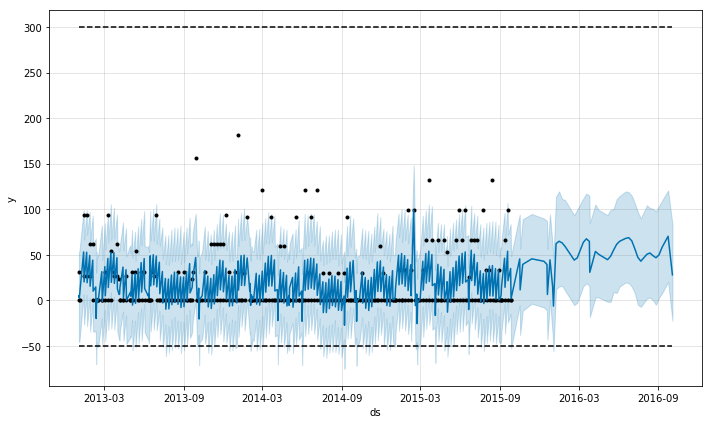

In [26]:
print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand1_restday.plot(forcast_brand1_restday)

In [27]:
df_brand1_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 1) 
                                          & (train_data.date_property == 0)]
df_brand1_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand1_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand1_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 1) & (test_data.date_property == 0)]
m_brand1_workday, forcast_brand1_workday = predictByProphet(df_brand1_workday, test_data_brand1_workday, holidays, 1500, -50, 1500, 0.5,
                0.95, df_brand1_workday_regressor_set, brand1_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
840 2016-05-17  321.817043   70.413821  586.511083
841 2016-05-18  278.371855    4.509881  516.925403
842 2016-05-19  220.155167  -21.082718  468.191105
843 2016-05-20  260.577571   -3.068047  497.790805
844 2016-05-23  318.319723   64.078923  547.925278
845 2016-05-24  313.740461   81.003968  551.475058
846 2016-05-25  270.552230    4.958551  503.670253
847 2016-05-26  212.328361  -37.296518  469.027388
848 2016-05-27  252.473497   12.495627  523.136453
849 2016-05-30  307.906127   57.306628  543.236658
850 2016-05-31  302.177208   47.486580  542.398678
851 2016-06-01  257.735016   28.539134  511.207699
852 2016-06-02  198.218524  -48.525445  453.798033
853 2016-06-03  237.104654  -11.411847  467.169233
854 2016-06-06  289.731061   27.609797  517.829990
855 2016-06-07  283.642909   23.968564  532.080950
856 2016-06-08  239.244140  -14.080137  491.758298
857 2016-06-12  452.918324  217.111160  692.843511
858 2016-06-13  331.401043   89

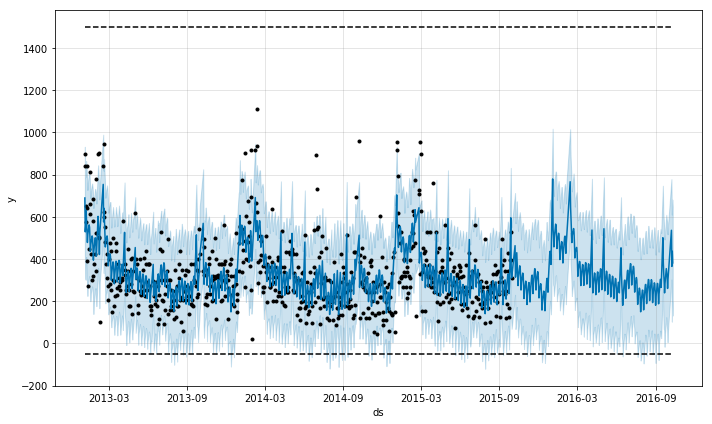

In [28]:
print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand1_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand1_workday.ds < '2016-01-10') & (forcast_brand1_workday.ds > '2016-01-01')])
m_brand1_workday.plot(forcast_brand1_workday)

In [29]:
brand1_result = pd.concat([forcast_brand1_workday, forcast_brand1_restday])
brand1_result = brand1_result.sort_values(by='ds', ascending=True)
print(brand1_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
854 2016-06-06  289.731061   27.609797  517.829990
855 2016-06-07  283.642909   23.968564  532.080950
856 2016-06-08  239.244140  -14.080137  491.758298
857 2016-06-12  452.918324  217.111160  692.843511
858 2016-06-13  331.401043   89.422798  568.484126
859 2016-06-14  276.066072   31.258136  520.711313
860 2016-06-15  235.308834    9.322254  487.422019
861 2016-06-16  180.367664  -61.984425  421.009373
862 2016-06-17  224.691836  -17.941953  474.406299
343 2016-06-18   67.962741   19.572190  119.475402
863 2016-06-20  298.099386   45.780320  543.116208
864 2016-06-21  300.052778   42.103173  566.013015
865 2016-06-22  264.003738   32.214750  513.972116
866 2016-06-23  213.467398  -29.017401  465.915984
867 2016-06-24  261.770443   11.604190  496.476535
344 2016-06-25   68.719649   18.856159  118.679034
868 2016-06-27  343.436079   98.876471  598.303399
869 2016-06-28  346.599139   99.707395  601.902897
870 2016-06-29  310.868882   49

In [30]:
df_brand2_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand2_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand2_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand2_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property != 0)]
m_brand2_restday, forcast_brand2_restday = predictByProphet(df_brand2_restday, test_data_brand2_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand2_restday_regressor_set, brand2_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
253 2015-03-14  34.507371   -9.932246   81.330610
254 2015-03-15   4.332000  -41.271446   54.700110
255 2015-03-21  35.958651  -11.406245   85.051725
256 2015-03-22   5.300078  -43.539673   53.622227
257 2015-03-28  34.002936  -12.044266   81.764498
258 2015-03-29   2.988645  -45.365530   53.793326
259 2015-04-04  19.821734  -25.780887   64.011147
260 2015-04-05   0.528167  -49.364518   46.210854
261 2015-04-06   8.808243  -36.981759   56.631020
262 2015-04-11  30.282895  -18.460356   77.975391
263 2015-04-12  -0.165883  -44.895089   49.169238
264 2015-04-18  32.117896  -17.898867   85.617154
265 2015-04-19   1.967198  -42.974242   51.247323
266 2015-04-25  35.628754  -16.004734   81.467923
267 2015-04-26   5.669952  -43.110925   51.636147
268 2015-05-01  12.448438  -38.212646   58.695386
269 2015-05-02  24.417289  -23.625038   72.300936
270 2015-05-03  -5.340424  -51.370239   40.693155
271 2015-05-09  46.436104   -2.127235   93.117011


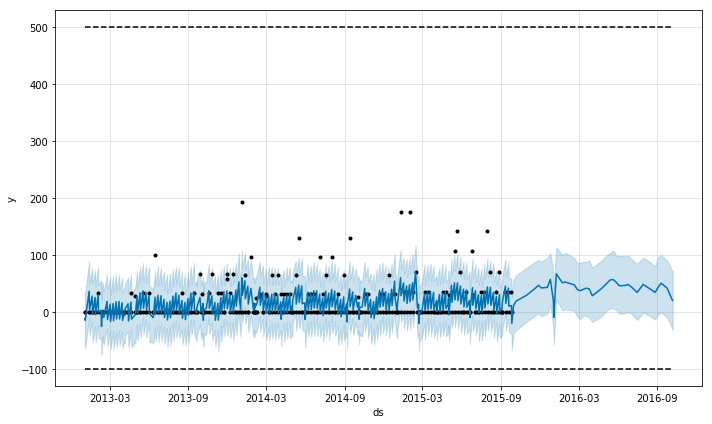

In [31]:
print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_restday.ds < '2016-01-10') & (forcast_brand1_restday.ds > '2016-01-01')])
m_brand2_restday.plot(forcast_brand2_restday)

In [32]:
df_brand2_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 2) 
                                          & (train_data.date_property == 0)]
df_brand2_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand2_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand2_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 2) & (test_data.date_property == 0)]
m_brand2_workday, forcast_brand2_workday = predictByProphet(df_brand2_workday, test_data_brand2_workday, holidays, 1500, -200, 800, 0.5,
                0.95, df_brand2_workday_regressor_set, brand2_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
840 2016-05-17  286.731196   78.282298  510.180615
841 2016-05-18  269.873657   55.461643  479.103375
842 2016-05-19  192.207277  -15.095097  397.745430
843 2016-05-20  230.400561   31.365362  449.091307
844 2016-05-23  234.182312   14.460586  452.294969
845 2016-05-24  256.478993   62.384326  461.715113
846 2016-05-25  238.061447   18.271723  450.882493
847 2016-05-26  159.212177  -49.129426  371.334694
848 2016-05-27  196.607741   -0.095839  410.960846
849 2016-05-30  200.294479  -13.060756  421.673016
850 2016-05-31  223.291808   30.520680  438.216177
851 2016-06-01  205.910801    1.179577  410.997557
852 2016-06-02  128.408791  -93.149535  327.568076
853 2016-06-03  167.433313  -50.789244  375.598993
854 2016-06-06  177.362915  -18.522578  378.462496
855 2016-06-07  202.771980   15.481013  426.787625
856 2016-06-08  187.905021  -23.222053  407.727817
857 2016-06-12  276.530531   55.910516  488.196647
858 2016-06-13  232.694538   14

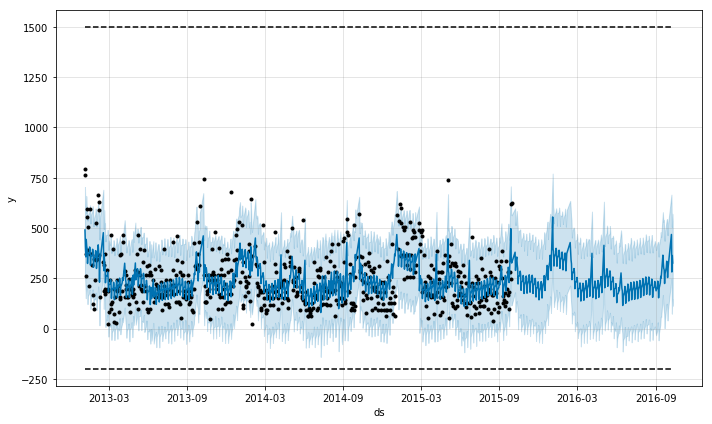

In [33]:
print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand2_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand2_workday.ds < '2016-01-10') & (forcast_brand2_workday.ds > '2016-01-01')])
m_brand2_workday.plot(forcast_brand2_workday)

In [34]:
brand2_result = pd.concat([forcast_brand2_workday, forcast_brand2_restday])
brand2_result = brand2_result.sort_values(by='ds', ascending=True)
print(brand2_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
853 2016-06-03  167.433313  -50.789244  375.598993
340 2016-06-04   45.679367   -3.614500   98.071081
854 2016-06-06  177.362915  -18.522578  378.462496
855 2016-06-07  202.771980   15.481013  426.787625
856 2016-06-08  187.905021  -23.222053  407.727817
857 2016-06-12  276.530531   55.910516  488.196647
858 2016-06-13  232.694538   14.458779  462.025867
859 2016-06-14  199.965658   -4.245080  410.053921
860 2016-06-15  187.351649  -24.636854  398.317024
861 2016-06-16  114.531654 -114.473230  326.582899
862 2016-06-17  158.097557  -57.749109  366.620553
341 2016-06-18   46.158329   -2.621484   97.534106
863 2016-06-20  180.329589  -40.905404  388.282349
864 2016-06-21  209.269026    7.810222  420.648045
865 2016-06-22  197.598036  -25.703804  417.721766
866 2016-06-23  125.516256  -83.118886  323.577454
867 2016-06-24  169.620826  -39.342748  380.522824
342 2016-06-25   47.855804   -0.521138   98.551844
868 2016-06-27  192.362680  -36

In [35]:
df_brand3_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand3_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand3_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand3_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property != 0)]
m_brand3_restday, forcast_brand3_restday = predictByProphet(df_brand3_restday, test_data_brand3_restday, holidays, 200, -300, 250, 0.5,
                0.95, df_brand3_restday_regressor_set, brand3_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
259 2015-04-04  11.268549  -31.668678   53.627395
260 2015-04-05  -4.570512  -50.655515   40.859619
261 2015-04-06  -2.113582  -47.796913   39.892575
262 2015-04-11  25.905978  -15.569316   69.007232
263 2015-04-12  -1.434900  -45.517557   42.952198
264 2015-04-18  33.759236  -10.826930   77.794049
265 2015-04-19   6.380964  -35.608624   53.142973
266 2015-04-25  38.689040   -9.077219   79.952981
267 2015-04-26  10.488848  -34.362508   54.306186
268 2015-05-01  -2.287470  -45.546036   44.182812
269 2015-05-02  10.487803  -34.172770   51.461374
270 2015-05-03 -18.552419  -59.563584   26.393854
271 2015-05-09  31.721156  -11.428227   72.831287
272 2015-05-10   2.451192  -42.967908   49.056388
273 2015-05-16  26.336565  -18.941204   70.084959
274 2015-05-17  -2.637466  -49.586633   40.488671
275 2015-05-23  23.363750  -20.765400   68.344524
276 2015-05-24  -5.289994  -49.231877   38.669541
277 2015-05-30  22.031847  -18.262318   65.778272


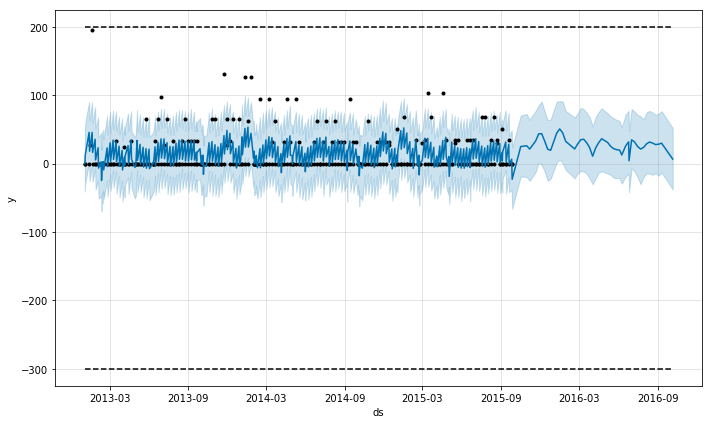

In [36]:
print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_restday.ds < '2016-01-10') & (forcast_brand3_restday.ds > '2016-01-01')])
m_brand3_restday.plot(forcast_brand3_restday)

In [37]:
df_brand3_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 3) 
                                          & (train_data.date_property == 0)]
df_brand3_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand3_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand3_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 3) & (test_data.date_property == 0)]
m_brand3_workday, forcast_brand3_workday = predictByProphet(df_brand3_workday, test_data_brand3_workday, holidays, 1500, -100, 1000, 0.5,
                0.95, df_brand3_workday_regressor_set, brand3_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
840 2016-05-17  423.633412  218.070876  640.932900
841 2016-05-18  397.996923  185.334028  612.988126
842 2016-05-19  343.738843  132.162485  559.300511
843 2016-05-20  375.631761  159.914471  580.489477
844 2016-05-23  407.899189  188.775918  608.913865
845 2016-05-24  417.838377  201.270064  643.529997
846 2016-05-25  392.148887  182.772884  603.142705
847 2016-05-26  337.936901  137.000670  536.658315
848 2016-05-27  369.956917  139.299297  574.395558
849 2016-05-30  402.905840  187.822674  624.378692
850 2016-05-31  413.113490  187.876020  623.081395
851 2016-06-01  387.687470  174.834912  597.286442
852 2016-06-02  333.721897  108.158697  560.967148
853 2016-06-03  365.961948  152.367568  580.967331
854 2016-06-06  399.364680  181.108626  614.860996
855 2016-06-07  409.654102  193.745379  613.509138
856 2016-06-08  384.281941  178.257327  590.323120
857 2016-06-12  493.351854  285.956779  720.344161
858 2016-06-13  400.446593  177

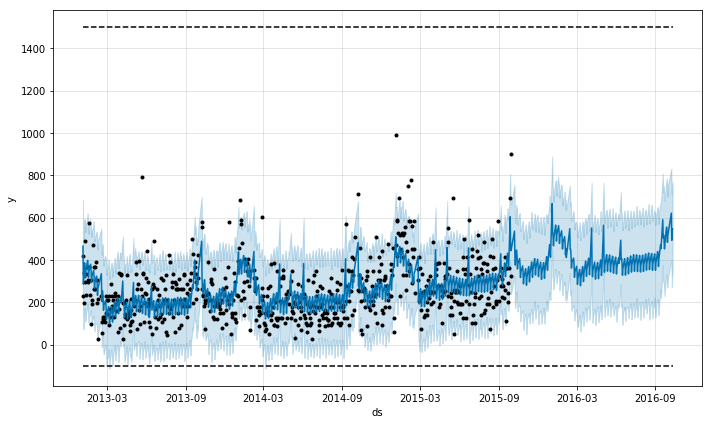

In [38]:
print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand3_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand3_workday.ds < '2016-01-10') & (forcast_brand3_workday.ds > '2016-01-01')])
m_brand3_workday.plot(forcast_brand3_workday)

In [39]:
brand3_result = pd.concat([forcast_brand3_workday, forcast_brand3_restday])
brand3_result = brand3_result.sort_values(by='ds', ascending=True)
print(brand3_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
856 2016-06-08  384.281941  178.257327  590.323120
343 2016-06-09   12.729192  -29.212702   53.275342
857 2016-06-12  493.351854  285.956779  720.344161
858 2016-06-13  400.446593  177.426024  631.719188
859 2016-06-14  406.533511  191.403054  620.549238
860 2016-06-15  381.312423  160.097581  611.088793
861 2016-06-16  327.591298   93.587572  540.080697
862 2016-06-17  360.133349  142.999442  561.621819
344 2016-06-18   25.802073  -19.034680   71.675942
863 2016-06-20  394.949964  169.279866  624.216664
864 2016-06-21  405.922350  180.162882  633.049641
865 2016-06-22  381.351727  159.513333  590.191089
866 2016-06-23  328.341466  111.545861  550.113853
867 2016-06-24  361.643279  162.788716  578.899002
345 2016-06-25   31.948223  -14.428851   77.385239
346 2016-06-26    4.285920  -42.072055   46.825756
868 2016-06-27  398.882198  176.778898  623.362144
869 2016-06-28  410.650842  181.797959  636.132617
870 2016-06-29  386.838969  179

In [40]:
df_brand4_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand4_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand4_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand4_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property != 0)]
m_brand4_restday, forcast_brand4_restday = predictByProphet(df_brand4_restday, test_data_brand4_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand4_restday_regressor_set, brand4_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
262 2015-04-11  45.117930    2.966546   88.523561
263 2015-04-12   3.267371  -39.045378   44.963885
264 2015-04-18  44.871391   -0.132159   87.106718
265 2015-04-19   2.799410  -44.330939   44.666108
266 2015-04-25  42.326545   -3.463488   87.448840
267 2015-04-26  -0.089744  -43.285641   41.567340
268 2015-05-01  10.709878  -30.697165   55.411857
269 2015-05-02  20.936868  -22.497321   66.058769
270 2015-05-03 -21.311951  -62.719244   23.473837
271 2015-05-09  38.013469   -7.953982   81.042434
272 2015-05-10  -3.518300  -48.465141   39.882529
273 2015-05-16  42.394834   -0.009607   86.528619
274 2015-05-17   1.404788  -40.364435   49.526811
275 2015-05-23  48.234534    7.126360   92.703900
276 2015-05-24   6.955345  -34.143123   52.494089
277 2015-05-30  49.903571    3.545485   90.623724
278 2015-05-31   7.765579  -36.403238   51.739690
279 2015-06-06  46.144836    2.126912   90.048940
280 2015-06-07   3.523938  -42.451628   44.940394


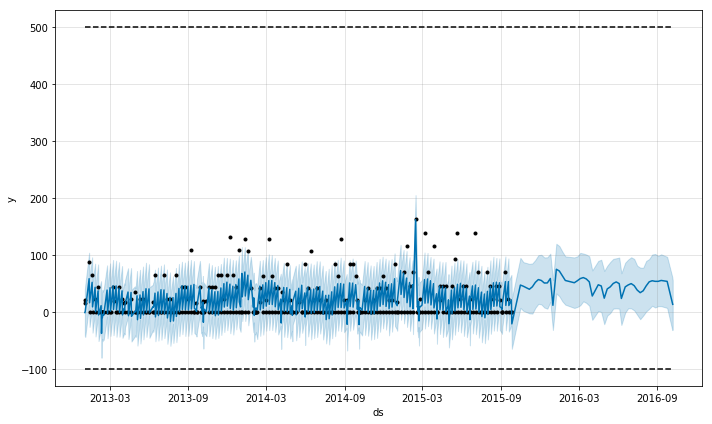

In [41]:
print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_restday.ds < '2016-01-10') & (forcast_brand4_restday.ds > '2016-01-01')])
m_brand4_restday.plot(forcast_brand4_restday)

In [42]:
df_brand4_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 4) 
                                          & (train_data.date_property == 0)]
df_brand4_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand4_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand4_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 4) & (test_data.date_property == 0)]
m_brand4_workday, forcast_brand4_workday = predictByProphet(df_brand4_workday, test_data_brand4_workday, holidays, 1500, -200, 1300, 0.5,
                0.95, df_brand4_workday_regressor_set, brand4_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
841 2016-05-18  396.040693  124.635423   659.913711
842 2016-05-19  277.374471   32.289532   538.670026
843 2016-05-20  321.212878   53.779475   582.424566
844 2016-05-23  414.477173  142.755585   655.547640
845 2016-05-24  469.283604  214.071570   734.339509
846 2016-05-25  359.302524   94.141558   619.941160
847 2016-05-26  245.152210  -28.042595   507.239616
848 2016-05-27  293.590304   15.764052   576.141789
849 2016-05-30  400.152599  143.923600   678.231960
850 2016-05-31  458.937907  202.097168   727.622266
851 2016-06-01  352.595795   75.292090   627.353519
852 2016-06-02  241.697561  -24.583891   499.426617
853 2016-06-03  292.968610   33.225809   562.063299
854 2016-06-06  405.409676  139.284808   693.573536
855 2016-06-07  465.312998  200.346310   713.455358
856 2016-06-08  359.712920   91.338262   625.102593
857 2016-06-12  540.289896  279.122167   809.814042
858 2016-06-13  413.273372  150.503184   684.439544
859 2016-06-

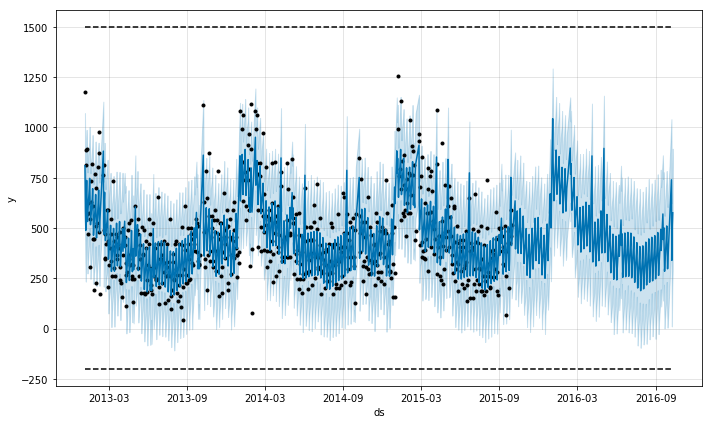

In [43]:
print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand4_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand4_workday.ds < '2016-01-10') & (forcast_brand4_workday.ds > '2016-01-01')])
m_brand4_workday.plot(forcast_brand4_workday)

In [44]:
brand4_result = pd.concat([forcast_brand4_workday, forcast_brand4_restday])
brand4_result = brand4_result.sort_values(by='ds', ascending=True)
print(brand4_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
857 2016-06-12  540.289896  279.122167   809.814042
858 2016-06-13  413.273372  150.503184   684.439544
859 2016-06-14  471.583932  220.640771   750.855897
860 2016-06-15  365.434327   88.122606   638.410756
861 2016-06-16  254.399336  -19.550302   514.606656
862 2016-06-17  305.284714   37.726592   571.547895
346 2016-06-18   43.673575   -1.577386    86.143958
863 2016-06-20  415.801978  136.807631   683.498110
864 2016-06-21  475.006991  190.643042   747.297597
865 2016-06-22  368.750715  100.490969   616.150110
866 2016-06-23  257.667730   -4.729843   542.087889
867 2016-06-24  308.539291   34.021324   572.464567
347 2016-06-25   47.110082    6.173287    91.744711
868 2016-06-27  418.905611  154.694927   705.115613
869 2016-06-28  477.907234  214.857311   756.419036
870 2016-06-29  371.313003  116.486302   653.122533
871 2016-06-30  259.726511  -19.661251   538.495823
872 2016-07-01  309.902874   32.931391   583.567810
348 2016-07-

In [45]:
df_brand6_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand6_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand6_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand6_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property != 0)]
m_brand6_restday, forcast_brand6_restday = predictByProphet(df_brand6_restday, test_data_brand6_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand6_restday_regressor_set, brand6_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
271 2015-05-03 -10.668738  -41.883815   19.103334
272 2015-05-09  49.322393   18.625141   82.132430
273 2015-05-10  14.653249  -16.964328   45.476614
274 2015-05-16  45.757808   14.283774   80.291639
275 2015-05-17  10.722138  -22.342317   43.548983
276 2015-05-23  41.032780    9.942847   71.645661
277 2015-05-24   6.068497  -26.084194   36.804667
278 2015-05-30  37.573083    6.308259   70.752759
279 2015-05-31   2.890481  -26.860042   32.616964
280 2015-06-06  36.301538    5.905725   67.850826
281 2015-06-07   1.960854  -29.190801   33.661823
282 2015-06-13  37.515711    5.309382   68.261740
283 2015-06-14   3.537386  -26.681304   35.310610
284 2015-06-20  24.663816   -7.532805   54.804264
285 2015-06-21  -9.069336  -40.432466   21.812085
286 2015-06-22  12.777286  -20.199901   45.885916
287 2015-06-27  45.342352   14.452653   76.502658
288 2015-06-28  11.502475  -19.515689   42.983135
289 2015-07-04  47.651336   13.585385   80.114107


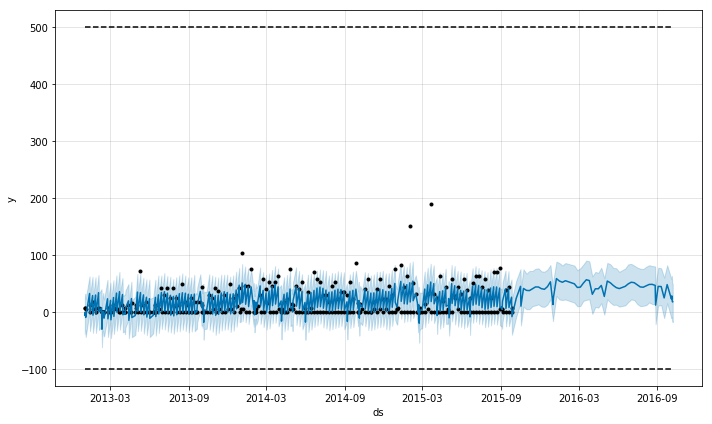

In [46]:
print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_restday.ds < '2016-01-10') & (forcast_brand6_restday.ds > '2016-01-01')])
m_brand6_restday.plot(forcast_brand6_restday)

In [47]:
df_brand6_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 6) 
                                          & (train_data.date_property == 0)]
df_brand6_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand6_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand6_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 6) & (test_data.date_property == 0)]
m_brand6_workday, forcast_brand6_workday = predictByProphet(df_brand6_workday, test_data_brand6_workday, holidays, 1000, -200, 700, 0.5,
                0.95, df_brand6_workday_regressor_set, brand6_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
841 2016-05-18  302.665095  170.116767  438.869788
842 2016-05-19  263.401056  136.627129  386.387643
843 2016-05-20  288.792121  159.134798  416.632005
844 2016-05-23  284.316169  145.418525  428.455762
845 2016-05-24  314.813202  186.096494  446.312713
846 2016-05-25  293.393922  157.224664  429.650358
847 2016-05-26  253.756684  109.282959  390.954425
848 2016-05-27  278.817478  148.066039  410.592345
849 2016-05-30  273.603501  141.579967  421.433543
850 2016-05-31  303.944641  173.888171  431.638321
851 2016-06-01  282.421422  155.322127  411.992070
852 2016-06-02  242.738601  106.027520  373.141703
853 2016-06-03  267.819841  121.616280  396.748371
854 2016-06-06  263.152388  141.530771  391.574813
855 2016-06-07  293.868336  160.646414  425.714857
856 2016-06-08  272.830636  134.157247  412.340892
857 2016-06-12  327.215099  207.844926  473.961960
858 2016-06-13  278.627834  147.363835  405.127799
859 2016-06-14  289.746374  154

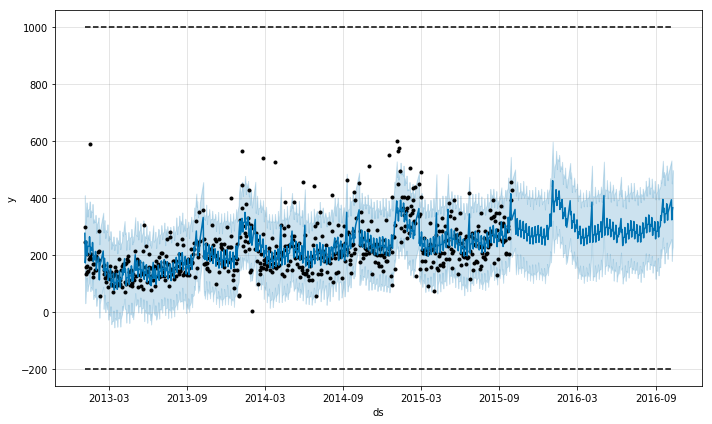

In [48]:
print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand6_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand6_workday.ds < '2016-01-10') & (forcast_brand6_workday.ds > '2016-01-01')])
m_brand6_workday.plot(forcast_brand6_workday)

In [49]:
brand6_result = pd.concat([forcast_brand6_workday, forcast_brand6_restday])
brand6_result = brand6_result.sort_values(by='ds', ascending=True)
print(brand6_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
861 2016-06-16  232.357088   98.950371  369.207699
862 2016-06-17  259.646791  119.026002  395.298468
351 2016-06-18   44.634778   11.265660   76.038193
863 2016-06-20  262.565678  127.215666  393.290003
864 2016-06-21  296.030163  163.084233  425.011388
865 2016-06-22  277.786968  139.896916  416.108778
866 2016-06-23  241.502401  108.707222  363.766167
867 2016-06-24  270.056257  143.506983  404.451003
352 2016-06-25   48.983142   17.079522   83.268239
868 2016-06-27  275.746111  137.497340  412.739589
869 2016-06-28  309.708937  179.117811  444.253673
870 2016-06-29  291.718321  154.476035  433.314343
871 2016-06-30  255.427875  120.007873  387.386960
872 2016-07-01  283.710360  155.635225  412.154601
353 2016-07-02   51.845225   21.624752   84.034474
873 2016-07-04  287.016168  158.931743  421.149733
874 2016-07-05  319.701142  187.842400  452.462280
875 2016-07-06  300.227247  166.609081  436.710809
876 2016-07-07  262.278844  135

In [50]:
df_brand7_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand7_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand7_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand7_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property != 0)]
m_brand7_restday, forcast_brand7_restday = predictByProphet(df_brand7_restday, test_data_brand7_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand7_restday_regressor_set, brand7_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
260 2015-04-05  -8.573146  -66.014886   46.297998
261 2015-04-06  11.102183  -43.733357   69.292529
262 2015-04-11  45.053678  -10.137241   96.769211
263 2015-04-12   7.961702  -48.677401   62.578112
264 2015-04-18  56.303503   -3.782334  111.667197
265 2015-04-19  20.272262  -34.485546   75.198646
266 2015-04-25  68.855557   10.257563  125.743446
267 2015-04-26  31.776626  -21.974779   87.638483
268 2015-05-01  13.520141  -43.858734   73.558024
269 2015-05-02  24.562043  -30.725719   78.492159
270 2015-05-03 -14.662298  -68.626828   41.051250
271 2015-05-09  57.853284    1.457512  113.252803
272 2015-05-10  17.786429  -37.801645   73.634147
273 2015-05-16  47.230317   -8.301367  100.921144
274 2015-05-17   8.543261  -49.821678   66.253817
275 2015-05-23  49.370693   -3.985255  107.878785
276 2015-05-24  12.614107  -40.074301   61.941870
277 2015-05-30  60.787936    2.784690  118.297857
278 2015-05-31  24.252330  -30.823847   83.733472


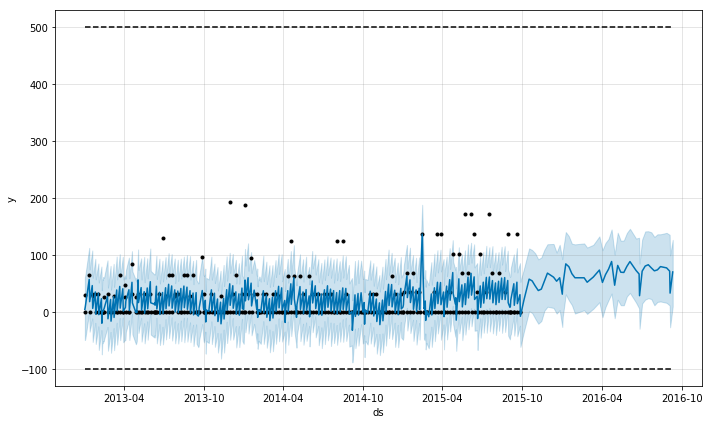

In [51]:
print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_restday.ds < '2016-01-10') & (forcast_brand7_restday.ds > '2016-01-01')])
m_brand7_restday.plot(forcast_brand7_restday)

In [52]:
df_brand7_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 7) 
                                          & (train_data.date_property == 0)]
df_brand7_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand7_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand7_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 7) & (test_data.date_property == 0)]
m_brand7_workday, forcast_brand7_workday = predictByProphet(df_brand7_workday, test_data_brand7_workday, holidays, 1000, -200, 750, 0.5,
                0.95, df_brand7_workday_regressor_set, brand7_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
841 2016-05-17  385.246442  162.846139  592.769348
842 2016-05-18  359.368632  142.313237  566.284735
843 2016-05-19  322.317913   99.782360  540.539738
844 2016-05-20  355.942118  140.333719  575.121625
845 2016-05-23  356.063399  139.458398  559.695955
846 2016-05-24  399.793825  173.747383  620.447585
847 2016-05-25  374.217818  148.300943  604.556922
848 2016-05-26  337.190823  121.088172  552.500990
849 2016-05-27  370.539495  152.879218  580.546059
850 2016-05-30  367.949827  145.660585  575.486616
851 2016-05-31  410.163031  194.185338  630.226368
852 2016-06-01  382.792760  149.105259  600.153543
853 2016-06-02  343.725299  113.009818  556.957660
854 2016-06-03  374.826004  154.060228  606.944384
855 2016-06-06  364.731857  150.746371  581.658863
856 2016-06-07  404.375354  184.463952  644.302387
857 2016-06-08  374.500788  150.952071  596.817423
858 2016-06-12  357.368230  128.119759  595.302128
859 2016-06-13  379.327423  171

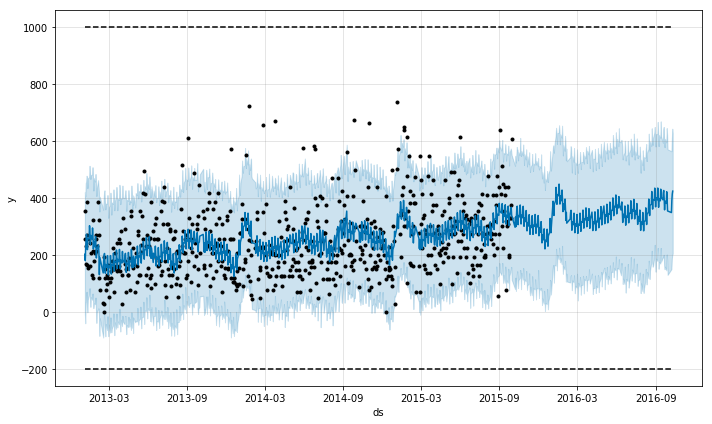

In [53]:
print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand7_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand7_workday.ds < '2016-01-10') & (forcast_brand7_workday.ds > '2016-01-01')])
m_brand7_workday.plot(forcast_brand7_workday)

In [54]:
brand7_result = pd.concat([forcast_brand7_workday, forcast_brand7_restday])
brand7_result = brand7_result.sort_values(by='ds', ascending=True)
print(brand7_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
855 2016-06-06  364.731857  150.746371  581.658863
856 2016-06-07  404.375354  184.463952  644.302387
857 2016-06-08  374.500788  150.952071  596.817423
858 2016-06-12  357.368230  128.119759  595.302128
859 2016-06-13  379.327423  171.527322  603.655729
860 2016-06-14  385.604602  163.708419  593.852598
861 2016-06-15  355.167841  143.098330  581.126790
862 2016-06-16  313.574598   97.624144  535.051933
863 2016-06-17  342.756046  116.233395  548.747490
346 2016-06-18   72.522776   16.109994  128.581853
864 2016-06-20  330.979949   97.912235  559.238932
865 2016-06-21  371.483601  158.595033  600.574184
866 2016-06-22  343.166297  116.080796  576.865510
867 2016-06-23  303.939898   67.173465  531.001807
868 2016-06-24  335.676269  115.033269  547.436061
347 2016-06-25   66.254787    5.921410  129.909770
348 2016-06-26   28.221482  -29.873703   84.497004
869 2016-06-27  332.028943  108.115053  550.813104
870 2016-06-28  375.163528  167

In [55]:
df_brand8_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand8_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand8_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand8_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property != 0)]
m_brand8_restday, forcast_brand8_restday = predictByProphet(df_brand8_restday, test_data_brand8_restday, holidays, 500, -100, 200, 0.5,
                0.95, df_brand8_restday_regressor_set, brand8_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
262 2015-04-11   8.164149  -19.159211   33.299262
263 2015-04-12  -2.372709  -30.629203   25.173496
264 2015-04-18   8.184935  -16.943816   34.383219
265 2015-04-19  -1.841403  -29.559292   24.308524
266 2015-04-25  10.828984  -16.880790   36.236308
267 2015-04-26   0.947326  -26.382575   28.245863
268 2015-05-01   4.937441  -20.609206   34.856339
269 2015-05-02   7.565361  -19.485059   34.809842
270 2015-05-03  -2.532768  -28.626916   25.663200
271 2015-05-09  13.905994  -14.050772   41.675153
272 2015-05-10   3.569135  -24.559484   31.135493
273 2015-05-16  13.462225  -11.946793   38.958174
274 2015-05-17   3.093974  -22.162439   30.448504
275 2015-05-23  13.292164  -13.997498   40.720865
276 2015-05-24   3.020680  -25.515512   29.035732
277 2015-05-30  13.720533  -15.809216   41.292096
278 2015-05-31   3.495578  -25.984675   30.133136
279 2015-06-06  14.212843  -12.685482   40.219117
280 2015-06-07   3.960456  -22.918926   33.049958


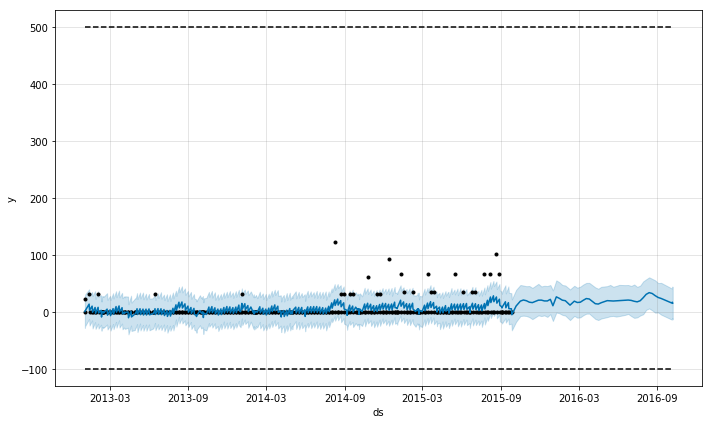

In [56]:
print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_restday.ds < '2016-01-10') & (forcast_brand8_restday.ds > '2016-01-01')])
m_brand8_restday.plot(forcast_brand8_restday)

In [57]:
df_brand8_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 8) 
                                          & (train_data.date_property == 0)]
df_brand8_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand8_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand8_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 8) & (test_data.date_property == 0)]
m_brand8_workday, forcast_brand8_workday = predictByProphet(df_brand8_workday, test_data_brand8_workday, holidays, 800, -300, 800, 0.5,
                0.95, df_brand8_workday_regressor_set, brand8_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
839 2016-05-16  524.767420  302.513850   768.295470
840 2016-05-17  541.601774  317.805416   792.857517
841 2016-05-18  516.021026  255.460715   770.750593
842 2016-05-19  489.700729  255.300736   725.437116
843 2016-05-20  505.814424  243.223042   763.084601
844 2016-05-23  521.018874  280.664897   773.658524
845 2016-05-24  538.979698  292.147930   808.891320
846 2016-05-25  514.530991  266.341459   764.400129
847 2016-05-26  489.320407  225.839145   762.190103
848 2016-05-27  506.494399  250.088150   758.775020
849 2016-05-30  524.340224  286.752199   776.209389
850 2016-05-31  542.934815  282.566230   783.458960
851 2016-06-01  518.972262  284.123514   793.578902
852 2016-06-02  494.092132  242.388866   745.523357
853 2016-06-03  511.437541  272.252877   765.712469
854 2016-06-06  528.883205  280.704995   776.674356
855 2016-06-07  547.076565  297.491037   806.705509
856 2016-06-08  522.608189  283.748836   780.082880
857 2016-06-

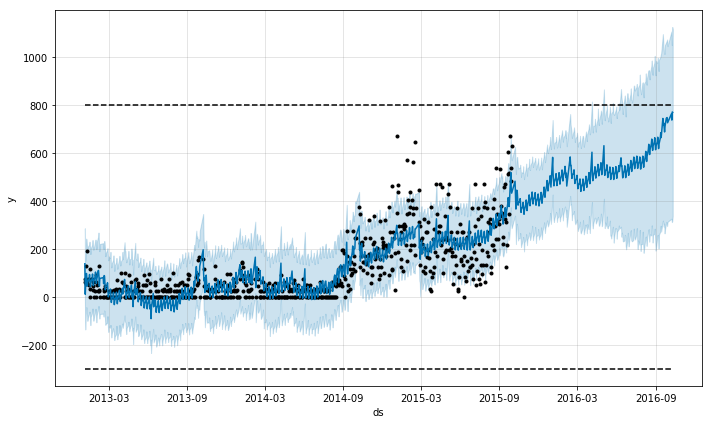

In [58]:
print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand8_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand8_workday.ds < '2016-01-10') & (forcast_brand8_workday.ds > '2016-01-01')])
m_brand8_workday.plot(forcast_brand8_workday)

In [59]:
brand8_result = pd.concat([forcast_brand8_workday, forcast_brand8_restday])
brand8_result = brand8_result.sort_values(by='ds', ascending=True)
print(brand8_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
855 2016-06-07  547.076565  297.491037   806.705509
856 2016-06-08  522.608189  283.748836   780.082880
857 2016-06-12  579.650551  292.354370   866.769009
858 2016-06-13  545.130218  250.448926   833.533562
859 2016-06-14  546.931587  267.436854   817.545627
860 2016-06-15  521.976042  259.341965   810.432295
861 2016-06-16  496.135662  232.991031   762.531471
862 2016-06-17  512.602000  230.905522   785.403483
346 2016-06-18   20.359331   -5.454953    46.772625
863 2016-06-20  528.347072  234.520130   828.356260
864 2016-06-21  546.414153  258.259145   839.810726
865 2016-06-22  522.088800  255.334035   807.579530
866 2016-06-23  497.051792  211.190322   752.130482
867 2016-06-24  514.481615  197.965759   801.888393
347 2016-06-25   20.552940   -3.802231    46.999751
868 2016-06-27  533.869779  239.994713   849.462739
869 2016-06-28  553.310598  266.792161   832.131208
870 2016-06-29  530.384302  225.170252   826.432684
871 2016-06-

In [60]:
df_brand10_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand10_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand10_changepoints_restday = ['2013-10-01', '2014-10-01']
test_data_brand10_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property != 0)]
m_brand10_restday, forcast_brand10_restday = predictByProphet(df_brand10_restday, test_data_brand10_restday, holidays, 500, -100, 180, 0.5,
                0.95, df_brand10_restday_regressor_set, brand10_changepoints_restday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
260 2015-04-05  16.662247  -28.176876   61.188956
261 2015-04-06  10.889300  -33.143009   58.497957
262 2015-04-11  46.832923    2.549208   89.699492
263 2015-04-12   3.884945  -38.869398   47.371150
264 2015-04-18  46.210517    3.429952   88.520684
265 2015-04-19   3.657944  -36.977733   49.103927
266 2015-04-25  46.579469    3.257247   94.301011
267 2015-04-26   3.794509  -36.572700   50.280754
268 2015-05-01   1.366354  -44.763148   43.777544
269 2015-05-02  16.571377  -26.587681   59.412134
270 2015-05-03 -26.735944  -69.279239   18.638807
271 2015-05-09  39.008698   -5.006629   84.261908
272 2015-05-10  -4.272136  -47.158181   39.201410
273 2015-05-16  36.606302   -8.656690   81.813346
274 2015-05-17  -5.924082  -48.609157   39.410472
275 2015-05-23  39.787079   -5.090985   83.756022
276 2015-05-24  -2.087620  -45.523045   47.934543
277 2015-05-30  45.068271   -1.444873   89.180229
278 2015-05-31   2.951062  -44.831367   49.363275


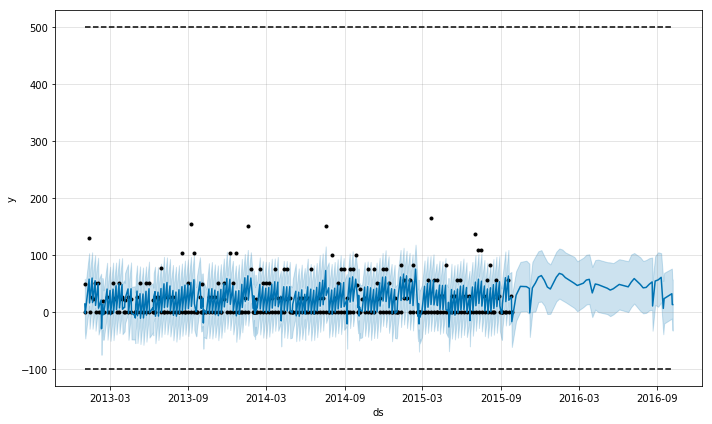

In [61]:
print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_restday.ds < '2016-01-10') & (forcast_brand10_restday.ds > '2016-01-01')])
m_brand10_restday.plot(forcast_brand10_restday)

In [62]:
df_brand10_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 10) 
                                          & (train_data.date_property == 0)]
df_brand10_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand10_changepoints_workday = ['2013-10-01', '2014-10-01']
test_data_brand10_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 10) & (test_data.date_property == 0)]
m_brand10_workday, forcast_brand10_workday = predictByProphet(df_brand10_workday, test_data_brand10_workday, holidays, 2000, 1000, 2000, 0.5,
                0.95, df_brand10_workday_regressor_set, brand10_changepoints_workday)

INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower   yhat_upper
840 2016-05-17  511.273112  177.282009   848.955333
841 2016-05-18  464.579854  126.206816   801.661907
842 2016-05-19  374.903219   34.521354   715.331575
843 2016-05-20  428.798627   84.236740   793.277108
844 2016-05-23  490.309095  144.716200   848.848195
845 2016-05-24  481.509479  142.852015   822.547731
846 2016-05-25  432.066990  104.553951   778.398039
847 2016-05-26  339.802759  -32.982051   667.804622
848 2016-05-27  391.292112   26.447287   747.082371
849 2016-05-30  446.902534   84.625585   766.315740
850 2016-05-31  436.661552   87.471703   778.655902
851 2016-06-01  386.087266   20.944841   726.090309
852 2016-06-02  293.030321  -81.106424   641.465278
853 2016-06-03  344.095516   21.170402   694.254096
854 2016-06-06  400.919844   72.244439   757.254175
855 2016-06-07  391.990217   55.452175   753.813800
856 2016-06-08  343.208876   12.109425   685.314016
857 2016-06-12  735.976515  412.883887  1070.579976
858 2016-06-

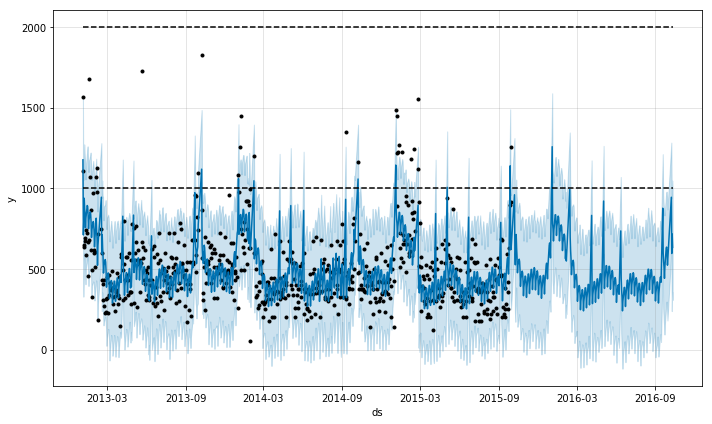

In [63]:
print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand10_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand10_workday.ds < '2016-01-10') & (forcast_brand10_workday.ds > '2016-01-01')])
m_brand10_workday.plot(forcast_brand10_workday)

In [64]:
brand10_result = pd.concat([forcast_brand10_workday, forcast_brand10_restday])
brand10_result = brand10_result.sort_values(by='ds', ascending=True)
print(brand10_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower   yhat_upper
857 2016-06-12  735.976515  412.883887  1070.579976
858 2016-06-13  444.688371  102.679075   798.124143
859 2016-06-14  369.883092   28.677641   703.761787
860 2016-06-15  326.031498  -29.932946   655.588001
861 2016-06-16  240.491036 -118.185236   573.891264
862 2016-06-17  299.802408  -37.429223   644.138096
863 2016-06-20  384.851699   32.242694   718.443701
864 2016-06-21  386.115715   52.144342   739.211629
865 2016-06-22  347.696686   -4.904369   679.068945
866 2016-06-23  267.301516  -77.979548   649.355851
867 2016-06-24  331.375658   -5.843960   678.770285
343 2016-06-25   43.763451   -0.540056    88.818271
868 2016-06-27  427.528152   87.676268   771.127125
869 2016-06-28  431.171200   88.735214   780.939599
870 2016-06-29  394.365580   60.756752   737.311889
871 2016-06-30  314.774795  -23.482642   660.415434
872 2016-07-01  378.816059   15.060423   708.158278
344 2016-07-02   51.952343    8.273072   100.548165
873 2016-07-

In [65]:
df_brand5_restday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & ((train_data.date_property == 1) | (train_data.date_property == 2))]
df_brand5_restday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'is_newYearDay', 
                                  'is_NationalDay', 'is_ChineseNewYearDay', 'after_restday_one',
                                  'is_holi_restday', 'isHolidayWeekend', 'isPureWeekend']
brand5_changepoints_restday = ['2014-10-01']
test_data_brand5_restday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property != 0)]
m_brand5_restday, forcast_brand5_restday = predictByProphet(df_brand5_restday, test_data_brand5_restday, holidays, 200, -100, 200, 0.5,
                0.95, df_brand5_restday_regressor_set, brand5_changepoints_restday)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds       yhat  yhat_lower  yhat_upper
85  2015-03-29   2.765604  -27.655795   31.055319
86  2015-04-04   5.641360  -23.729642   36.712881
87  2015-04-05  -6.989870  -35.681514   24.399580
88  2015-04-06   1.382946  -27.077071   31.457019
89  2015-04-11  16.518133  -12.556718   45.936238
90  2015-04-12   3.132472  -25.156635   33.451405
91  2015-04-18  16.701534  -14.468394   49.491989
92  2015-04-19   3.315869  -28.692495   32.527530
93  2015-04-25  16.884911  -15.145660   46.249561
94  2015-04-26   3.499241  -26.511927   33.637808
95  2015-05-01   3.001216  -26.632924   30.403921
96  2015-05-02   5.210112  -24.709197   36.698178
97  2015-05-03  -8.175561  -38.477140   20.656001
98  2015-05-09  17.251586  -12.890840   47.400732
99  2015-05-10   3.865909  -26.879048   33.015268
100 2015-05-16  17.434884  -12.380572   46.655043
101 2015-05-17   4.049203  -24.061005   33.971455
102 2015-05-23  17.618155  -13.216380   51.099211
103 2015-05-24   4.232470  -26.504941   33.008783


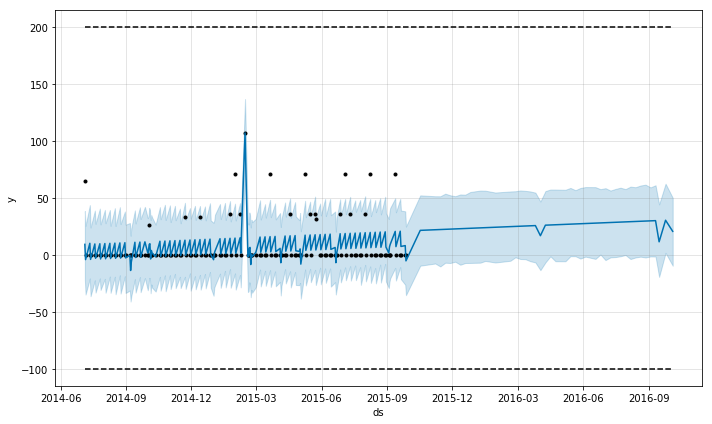

In [66]:
print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_restday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_restday.ds < '2016-01-10') & (forcast_brand5_restday.ds > '2016-01-01')])
m_brand5_restday.plot(forcast_brand5_restday)

In [67]:
df_brand5_workday = df_allBrand[['ds', 'y', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
                        'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                        'date_property_0', 'date_property_1', 'date_property_2',
                        'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                        'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                        'isPureWeekend']][(df_allBrand.brand == 5) 
                                          & (train_data.date_property == 0)]
df_brand5_workday_regressor_set = ['day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                                  'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 
                                'after_restday_one', 'after_holiday_one']
brand5_changepoints_workday = ['2014-10-01']
test_data_brand5_workday = test_data[['ds', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
                             'day_of_week_5', 'day_of_week_6', 'day_of_week_7',
                             'date_property_0', 'date_property_1', 'date_property_2',
                             'is_newYearDay', 'is_NationalDay', 'is_ChineseNewYearDay',
                            'after_restday_one', 'after_holiday_one', 'is_holi_restday', 'isHolidayWeekend',
                            'isPureWeekend']][(test_data.brand == 5) & (test_data.date_property == 0)]
m_brand5_workday, forcast_brand5_workday = predictByProphet(df_brand5_workday, test_data_brand5_workday, holidays, 1500, -100, 1500, 0.5,
                0.95, df_brand5_workday_regressor_set, brand5_changepoints_workday)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Found custom seasonality named "weekly", disabling built-in weekly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


            ds        yhat  yhat_lower  yhat_upper
463 2016-05-13  251.988764   42.844333  450.189440
464 2016-05-16  321.532195  109.859817  520.930967
465 2016-05-17  293.577616   94.320553  505.049539
466 2016-05-18  278.934009   74.773273  486.887827
467 2016-05-19  235.117423   33.813860  452.623839
468 2016-05-20  252.104925   45.720702  471.970376
469 2016-05-23  321.645740  113.533117  516.153651
470 2016-05-24  293.690303   63.378786  499.309895
471 2016-05-25  279.045844   51.996842  490.725156
472 2016-05-26  235.228411   34.455884  452.942094
473 2016-05-27  252.215074   34.662847  458.422565
474 2016-05-30  321.753409  108.474691  534.164949
475 2016-05-31  293.797157   83.799694  523.157242
476 2016-06-01  279.151890   65.460789  483.651724
477 2016-06-02  235.333655   36.113328  446.592100
478 2016-06-03  252.319521   49.973447  467.691284
479 2016-06-06  321.855504  122.963002  526.485813
480 2016-06-07  293.898480   78.254197  507.517488
481 2016-06-08  279.252446   51

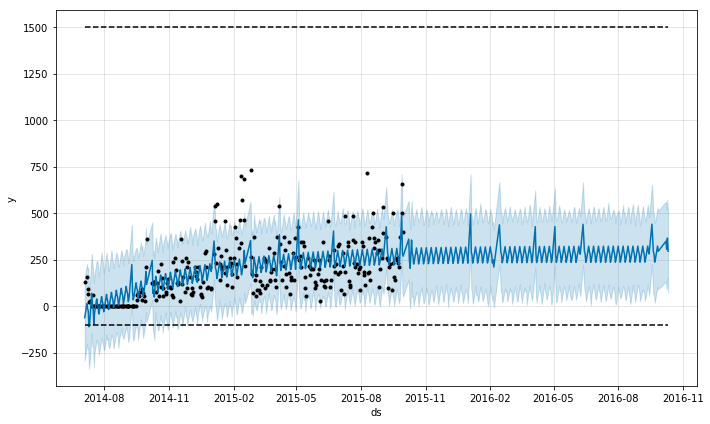

In [68]:
print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))
# print(forcast_brand5_workday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][(forcast_brand5_workday.ds < '2016-01-10') & (forcast_brand5_workday.ds > '2016-01-01')])
m_brand5_workday.plot(forcast_brand5_workday)

In [69]:
brand5_result = pd.concat([forcast_brand5_workday, forcast_brand5_restday])
brand5_result = brand5_result.sort_values(by='ds', ascending=True)
print(brand5_result[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100))

            ds        yhat  yhat_lower  yhat_upper
479 2016-06-06  321.855504  122.963002  526.485813
480 2016-06-07  293.898480   78.254197  507.517488
481 2016-06-08  279.252446   51.884423  480.486277
482 2016-06-12  439.707372  221.604629  664.760160
483 2016-06-13  365.020920  150.335675  563.248741
484 2016-06-14  293.994558   91.327449  508.345670
485 2016-06-15  279.347797   68.897844  492.736521
486 2016-06-16  235.528080   26.808863  446.270838
487 2016-06-17  252.512476   42.589687  472.219401
169 2016-06-18   27.821388   -3.594092   59.403456
488 2016-06-20  322.044112  106.313455  528.799688
489 2016-06-21  294.085661   88.253859  500.980582
490 2016-06-22  279.438211   49.760594  485.946162
491 2016-06-23  235.617810    3.146058  445.112278
492 2016-06-24  252.601527   61.151724  473.636417
170 2016-06-25   28.002225    0.240037   57.624035
493 2016-06-27  322.131157  118.795033  535.378723
494 2016-06-28  294.172047   87.086112  524.448842
495 2016-06-29  279.523943   60

In [70]:
#将分品牌预测出来的结果合并
def fillPredictResult(df_test_data, df_fill_data, brand):
    df_test_data['predict_result'][df_test_data.brand == brand] = df_fill_data['yhat'].values
    return df_test_data

test_data['predict_result'] = 10
test_data = test_data.drop_duplicates(['ds', 'brand'])
test_data = fillPredictResult(test_data, brand1_result[(brand1_result.ds < '2016-10-12') & (brand1_result.ds > '2015-09-30')], 1)
test_data = fillPredictResult(test_data, brand2_result[(brand2_result.ds < '2016-10-12') & (brand2_result.ds > '2015-09-30')], 2)
test_data = fillPredictResult(test_data, brand3_result[(brand3_result.ds < '2016-10-12') & (brand3_result.ds > '2015-09-30')], 3)
test_data = fillPredictResult(test_data, brand4_result[(brand4_result.ds < '2016-10-12') & (brand4_result.ds > '2015-09-30')], 4)
test_data = fillPredictResult(test_data, brand5_result[(brand5_result.ds < '2016-10-12') & (brand5_result.ds > '2015-09-30')], 5)
test_data = fillPredictResult(test_data, brand6_result[(brand6_result.ds < '2016-10-12') & (brand6_result.ds > '2015-09-30')], 6)
brand7_result = brand7_result.drop_duplicates(['ds'])
test_data = fillPredictResult(test_data, brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2015-09-30')], 7)
test_data = fillPredictResult(test_data, brand8_result[(brand8_result.ds < '2016-10-12') & (brand8_result.ds > '2015-09-30')], 8)
test_data = fillPredictResult(test_data, brand9_result[(brand9_result.ds < '2016-10-12') & (brand9_result.ds > '2015-09-30')], 9)
test_data = fillPredictResult(test_data, brand10_result[(brand10_result.ds < '2016-10-12') & (brand10_result.ds > '2015-09-30')], 10)
# print(len(test_data['predict_result'][test_data.brand == 7]))
# print(len(brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2016-05-04')]))
test_data['predict_result'] = test_data['predict_result'].map(lambda x: x if x >=5 else 10)
print(test_data[['ds', 'brand', 'day_of_week', 'date', 'predict_result']].head(100))

             ds  brand  day_of_week  date  predict_result
7253 2015-10-01      2            4   916       10.841668
7254 2015-10-01      9            4   916       39.590882
7255 2015-10-05      7            1   917       20.200411
7256 2015-10-07      2            3   918       18.774975
7257 2015-10-07      6            3   918       23.603887
7258 2015-10-07      8            3   918       10.085465
7259 2015-10-07      9            3   918       43.027866
7260 2015-10-07     10            3   918       29.058128
7261 2015-10-08      1            4   919      463.139705
7262 2015-10-08      2            4   919      379.531224
7263 2015-10-08      3            4   919      536.310522
7264 2015-10-08      4            4   919      635.000883
7265 2015-10-08      5            4   919      360.062178
7266 2015-10-08      6            4   919      359.298458
7267 2015-10-08      7            4   919      296.819838
7268 2015-10-08      8            4   919      482.070720
7269 2015-10-0

In [71]:
#导入A榜答案，计算预测误差
df_fusai_A_answer = pd.read_csv('fusai_answer_a_20180307.txt', sep='\t', header=None)
test_data2 = test_data2.drop_duplicates(['guess_date', 'brand'])
answer = pd.concat([test_data2['cnt'][test_data2.guess_date > '2015-09-31'], df_fusai_A_answer[1:][2]])
predict = test_data['predict_result']
print(len(answer))
print(len(test_data))
print(np.linalg.norm(predict - answer)**2 / len(predict))

3006
3006
48854.6073082


In [81]:
answer_brand = pd.concat([test_data2['cnt'][(test_data2.guess_date > '2015-09-31') & (test_data2.brand == 10)], 
                     df_fusai_A_answer[1:][2][df_fusai_A_answer[1] == 10]])
predict_brand = test_data['predict_result'][test_data.brand == 10]
print(np.linalg.norm(predict_brand - answer_brand)**2 / len(predict_brand))

26608.6487541


In [89]:
total_error = len(brand1_result[(brand1_result.ds < '2016-10-12') & (brand1_result.ds > '2015-09-30')]) * 31783 + len(brand2_result[(brand2_result.ds < '2016-10-12') & (brand2_result.ds > '2015-09-30')]) * 22273 + len(brand3_result[(brand3_result.ds < '2016-10-12') & (brand3_result.ds > '2015-09-30')]) * 15448 +len(brand4_result[(brand4_result.ds < '2016-10-12') & (brand4_result.ds > '2015-09-30')]) * 29902 +len(brand5_result[(brand5_result.ds < '2016-10-12') & (brand5_result.ds > '2015-09-30')]) * 38485 +len(brand6_result[(brand6_result.ds < '2016-10-12') & (brand6_result.ds > '2015-09-30')]) * 10627 +len(brand7_result[(brand7_result.ds < '2016-10-12') & (brand7_result.ds > '2015-09-30')]) * 19796 +len(brand8_result[(brand8_result.ds < '2016-10-12') & (brand8_result.ds > '2015-09-30')]) * 70151 +len(brand9_result[(brand9_result.ds < '2016-10-12') & (brand9_result.ds > '2015-09-30')]) * 204943 +len(brand10_result[(brand10_result.ds < '2016-10-12') & (brand10_result.ds > '2015-09-30')]) * 32589
total_error = total_error / len(test_data[(test_data.ds < '2016-10-12') & (test_data.ds > '2015-09-30')])
total_error

48970.35595475715